In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from scipy.optimize import fsolve
from scipy.stats import binom

In [2]:
infol = '/Users/irffanalahi/Research/Research_update/in-silico/theoritical_model/depth_30x/try1/trytoreproduce_real/read_counting_results'
infiles = os.listdir(infol)

infile_real = '/Users/irffanalahi/Research/Research_update/in-silico/theoritical_model/depth_30x/try1/trytoreproduce_real/92-reporter_estimated.txt'



#ground_truth_file = '92_reporter.txt'

if '.ipynb_checkpoints' in infiles:
    infiles.remove('.ipynb_checkpoints')
    
if '.DS_Store' in infiles:
    infiles.remove('.DS_Store')

num_groups = 3

cell = 'mNeu'
cell_real = 'mNeu_real'

#check_col1 = 'totalTestedreadCT'
#check_col2 = 'totalTestedreadnonCT'

check_col1 = 'totalTestedreadCTestimated'
check_col2 = 'totalTestedreadnonCTestimated'

FP_col = 'false_pos/all_neg'
check_col3 = 'totalTestedread'


adj = 0.95
out = 'multi_reporters.pdf'

f1 = np.logspace(0,-6,num=1000)
r1 = [(92, '')]

In [3]:
def generate_lists(df, cell_name):
    num = 0
    avg_vals = []
    avg_lst = np.zeros(num_groups)

    mNeu_arr = np.array(df[cell_name])
    for i in range(len(df)):
        if num == num_groups:
            avg_vals.append(np.mean(avg_lst))
            avg_lst = np.zeros(num_groups)
            num = 0
        avg_lst[num] = mNeu_arr[i]
        num += 1
    
    avg_vals.append(np.mean(avg_lst))

    return avg_vals

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_discrete_distns.py:62: RuntimeWarning: floating point number truncated to an integer
  vals = special.bdtr(k, n, p)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_discrete_distns.py:62: RuntimeWarning: floating point number truncated to an integer
  vals = special.bdtr(k, n, p)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_discrete_distns.py:62: RuntimeWarning: floating point number truncated to an integer
  vals = special.bdtr(k, n, p)


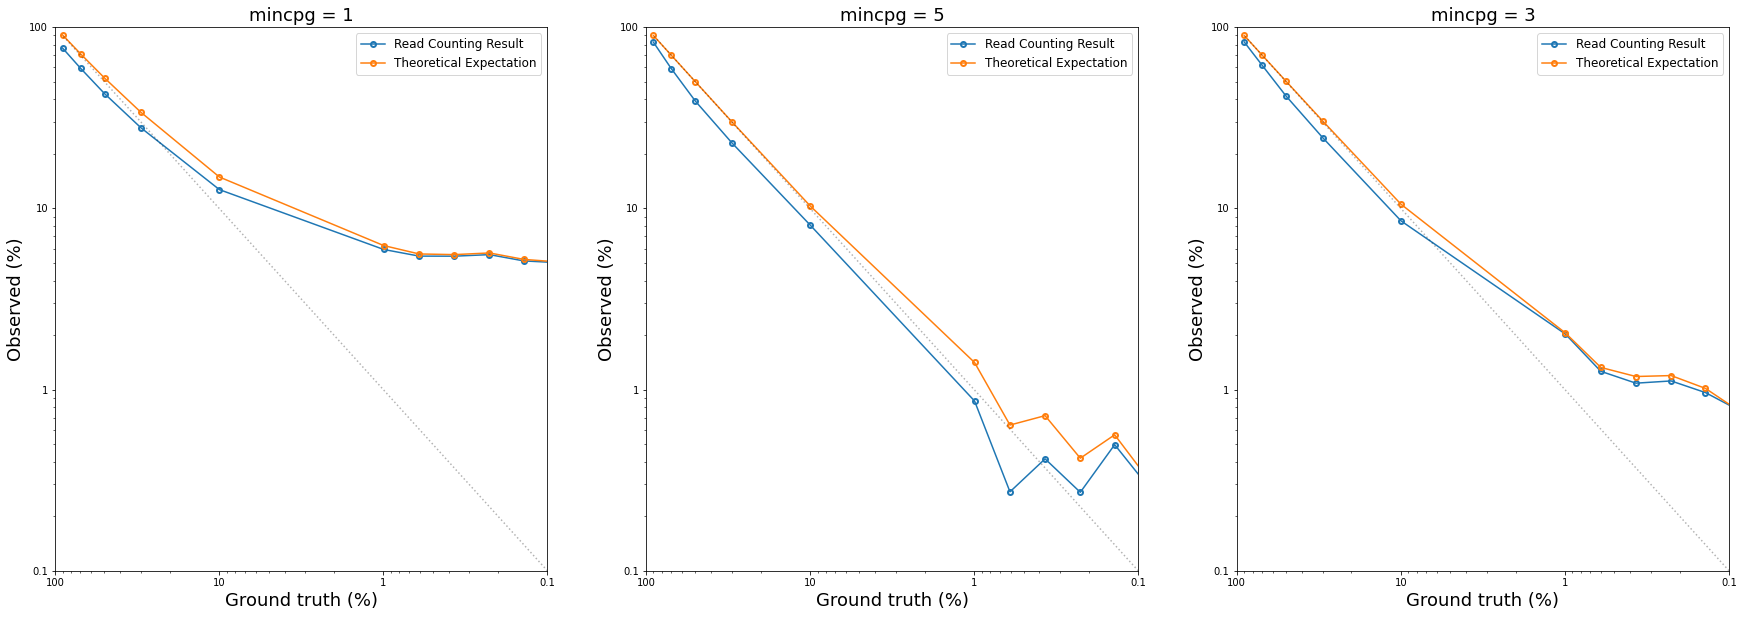

In [4]:
fig, axs = plt.subplots(1, len(infiles), figsize=(10 * len(infiles), 10))

color=plt.cm.rainbow(np.linspace(0,1,len(infiles)))


data_real = pd.read_csv(infile_real, sep='\t', index_col=0)
df_real = pd.DataFrame(data_real)

for i in range(len(infiles)):
    file_name = infiles[i]
    file = infol + '/' + file_name
    data = pd.read_csv(file, sep='\t', index_col=0)
    df = pd.DataFrame(data)
    
    file_split = file_name.split('mincpg')
    num_mincpg = int(file_split[1][0])
    df_mincpg = df_real[df_real['mincpg'] == num_mincpg].copy()

    df_subset = df.copy()
        
    df_subset['Index Number'] = [int(i.split('insilmix')[-1]) for i in df_subset.index]

    df_subset.sort_values(['Index Number'], inplace=True)
    df_subset = df_subset.drop('Index Number', axis=1)
    
    df_mincpg['Index Number'] = [int(i.split('insilmix')[-1]) for i in df_mincpg.index]

    df_mincpg.sort_values(['Index Number'], inplace=True)
    df_mincpg = df_mincpg.drop('Index Number', axis=1)
    
    d1 = np.mean(np.array(df_mincpg['totalTestedread']))
    
    df_subset = df_subset.loc[list(df_mincpg.index)].copy()
    
    depth = np.array(generate_lists(df_mincpg, check_col1))
    FP = np.array(generate_lists(df_mincpg, FP_col))
    depth_nonCT = np.array(generate_lists(df_mincpg, check_col2))
    depth_test = np.array(generate_lists(df_mincpg, check_col3))
    
    '''
    for col in df.columns:
        if 'real' not in col:
            df_subset[col] = np.array(df_subset[col]) * 100
    '''
        
    idx = list(df_subset.index)[0][:-1]
    x = generate_lists(df_mincpg, cell_real)
    y = generate_lists(df_subset, cell)
    
    # y = np.subtract(np.array(y), np.multiply(depth, FP))
        
    c = color[i]
    x, y, depth, FP, depth_nonCT, depth_test = zip(*sorted(zip(x, y, depth, FP, depth_nonCT, depth_test)))
    x = np.array(x) / 100
    prob = 1 - binom.cdf(0, d1, x)
    
    x_prob = np.multiply(depth, prob) + np.multiply(FP, depth_nonCT)
    x_prob = np.divide(x_prob, depth_test)
    
    x = x * 100
    y = np.array(y) * 100
    x_prob = x_prob * 100
    
    
    axs[i].plot(x, y, label='Read Counting Result', marker='o', mew=2, ms=5, fillstyle='none')
    axs[i].plot(x, x_prob, label='Theoretical Expectation', marker='o', mew=2, ms=5, fillstyle='none')
    axs[i].plot(x, x, alpha=0.3, ls=':', c='k')
    axs[i].invert_xaxis()
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_xlim([100,0.1])
    axs[i].set_ylim([0.1,100])
    axs[i].set_xlabel('Ground truth (%)', fontsize=18)
    axs[i].set_ylabel('Observed (%)', fontsize=18)
    axs[i].xaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:g}'.format(y)))
    axs[i].yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:g}'.format(y)))
    axs[i].set_title('mincpg = ' + str(num_mincpg), fontsize=18)
    axs[i].legend(fontsize=12)

In [5]:
fig.savefig(infile_real+'plot_g_binomtest.pdf',dpi=300, bbox_inches='tight')